# Ridge Regression in R

## Install & Load Libraries

In [24]:
#install.packages(c('glmnet', 'ggplot2', 'tidyr', 'dplyr')

library(glmnet)
library(ggplot2)
library(tidyr)
library(dplyr)

## Create Sample Dataset

As mentioned above, Ridge is useful in situations where there could be noise in your training data, and when there is multicollinearity, but removing features from your model may be undesirable. 

To demonstrate this, we will create sample data with linear relationships between the predictors and the outcome, and then we will add in some collinearity. We will also add in some irrelevant features, to show how the addition of the regularization penalty $\lambda $ minimizes their impact relative to OLS by shrinking coefficients.

Below is an example of a scenario where a dataset like the one we generate could be used in real life:

#### **Predicting Energy Efficiency of Buildings**

#### Background:
The construction industry is increasingly focused on building energy-efficient structures to reduce energy consumption and minimize environmental impact. As part of this effort, researchers and engineers are interested in predicting the energy efficiency of buildings based on various design and environmental features.

#### Dataset Overview
- **Objective**: The goal is to predict the energy efficiency of a building, which is quantified by a specific metric (e.g., heating load, cooling load). This metric is influenced by various architectural and material features of the building.
- **Features**: The dataset consists of 100 features (n_features = 100) that represent different aspects of the building's design and surrounding environment. These could include wall materials, insulation thickness, window type, orientation, surrounding vegetation, and local climate conditions, among others.
- **Samples**: There are 1,000 buildings (n_samples = 1000) in the dataset, each with measurements or specifications for the 100 features.
- **Noise**: The dataset includes a level of noise (noise_level = 5) to account for measurement errors or unobserved variables that might affect the energy efficiency metric.
- **Sparsity and Relevance**: Out of the 100 features, only 10 are truly relevant to predicting energy efficiency, mimicking the real-world scenario where only a subset of features significantly impacts the outcome. These relevant features have varying degrees of influence, represented by the true coefficients generated with a normal distribution.
- **Multicollinearity**: The features exhibit multicollinearity, where some features are highly correlated with each other. This is common in real-world data, as certain design aspects of buildings might be related (e.g., the use of specific materials might correlate with insulation properties).

#### **Prediction Task**
Using this dataset, the task is to develop a predictive model that can accurately estimate the energy efficiency of a building based on the 100 features. The model needs to handle multicollinearity among features and identify the truly relevant features that impact energy efficiency.

In [3]:
set.seed(42) # Ensure reproducibility

n_features <- 100 # 
n_samples <- 1000 # Number of samples
noise_level <- 5 # Noise level

### Generate True Coefficients of Features

We'll create a vector that represents the true value of the coefficients of our features. As you can see, we are deliberately creating features with sparce coefficients (values with O as the true value). 

We will later add in noise so that true feature values are not zero, but this is done to show where Ridge would be preferable to OLS, as Ridge's shrinkage penalty will reduce coefficient sizes, minimizng the impact of sparse features.

Some features are also given a true value of 10, to represent features that aren't really correlated with the outcome variable (sometimes it is unfeasible or impossible to remove these features).

In [4]:
# Generate true coefficients with sparsity and relevance
true_coef <- rep(0, n_features)
# Designate 10 features as relevant
true_coef[sample(1:n_features, 10)] <- rnorm(10, mean = 10, sd = 5) 


### Generate Design Matrix & Introduce Collinearity

Below we'll create a design matrix used to store our sample data. The rows of a design matrix correspond to individual samples, and the columns correspond to features. Each cell in the design matrix corresponds to the value of a specific feature for an individual sample. The cells are drawn from a normal distribution.

The loop introduces collinearity, which is deliberately added by making each feature a linear combination of the previous feature, plus some added noise. In OLS, collinearity can cause extreme fluctuations in estimates for small changes in a variable's value. The regularization penalty minimizes the impact of this as well see later on. 

In [5]:
# Generate design matrix X with correlated features
X <- matrix(rnorm(n_samples * n_features), nrow = n_samples, ncol = n_features)
for (i in 1:(n_features - 1)) {
  X[, i + 1] <- 0.5*X[, i] + rnorm(n_samples) # Introduce multicollinearity
}

### Create Outcome Variable

Our outcome variable will be our design matrix multiplied by our coefficient vector plus some noise added in. In our scenario, the outcome variable will correspond to a building's energy efficiency:

In [6]:
# Generate target variable y with linear relationship and noise
y <- X %*% true_coef + rnorm(n_samples, mean = 0, sd = noise_level)

And we will now turn this into a dataframe:

In [7]:
df <- data.frame(X)
df$Y <- y

In [8]:
head(df)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
1,0.9657529,-0.2395223,0.3632294,0.29061871,0.25327401,0.40410992,1.5071103,-0.2338969,-1.09316976,-0.4846328,...,0.65948255,-0.9147245,-0.1791062,0.2876812,0.6391476,-0.6969199,-0.4213185,1.93392633,1.2306341,18.688032
2,-0.8145709,-0.9070542,0.7457213,0.56187952,0.02481809,-0.60329287,-2.5559222,-1.4274201,-0.16495024,0.2747062,...,-0.90756034,-1.1642252,-0.8336234,0.1771457,0.6565814,2.1180645,0.1524654,-0.08624782,-0.7313618,46.780053
3,0.2839578,-1.0165762,-1.1396477,-2.06636522,-1.37376134,-0.07512175,-0.1897140,0.4425120,-0.91065195,0.9226869,...,1.43131948,1.4055601,-0.9541143,-1.3547395,0.1925453,0.0951924,-0.5989862,-0.09742201,0.7448470,-2.612621
4,-0.1616986,0.5497941,-1.4030524,-1.63495833,-1.09035071,0.83234317,-0.6451903,-0.8924683,0.07419801,-0.4268678,...,-0.08750008,0.2317831,-0.7562357,-1.8026337,-0.1767202,-0.2162064,0.1730193,0.17940529,-2.5774373,-66.726144
5,1.9355718,0.8647940,0.4647923,0.02771515,1.20306324,-1.63169730,-0.7237139,1.0121204,-0.01372930,0.2026309,...,-1.73760988,-0.7962516,-0.9183140,-1.9147317,-1.0478065,-0.1884870,-0.9332155,-1.17675060,-0.2826209,-59.168917
6,1.7232308,0.7496086,-0.5450245,1.04940797,2.14085086,0.69570137,0.3016519,0.5040224,-0.94126335,-0.8135204,...,0.52205375,-1.5578689,-1.0202859,-1.7094271,0.8314484,-1.7062715,0.1959959,-0.36038241,0.5133610,-14.841597


### Exploratory Data Analysis & Visualization

Since we generated our data synthetically and already know our data's distribution and the relationships between our predictors and outcome, this process is less applicable.

Let's create a scatter plot to visualize the relationship between some of our features and our outcome variable. Scatterplots can help identify correlations between features, and identify outliers:



Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(selected_predictors)

  # Now:
  data %>% select(all_of(selected_predictors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


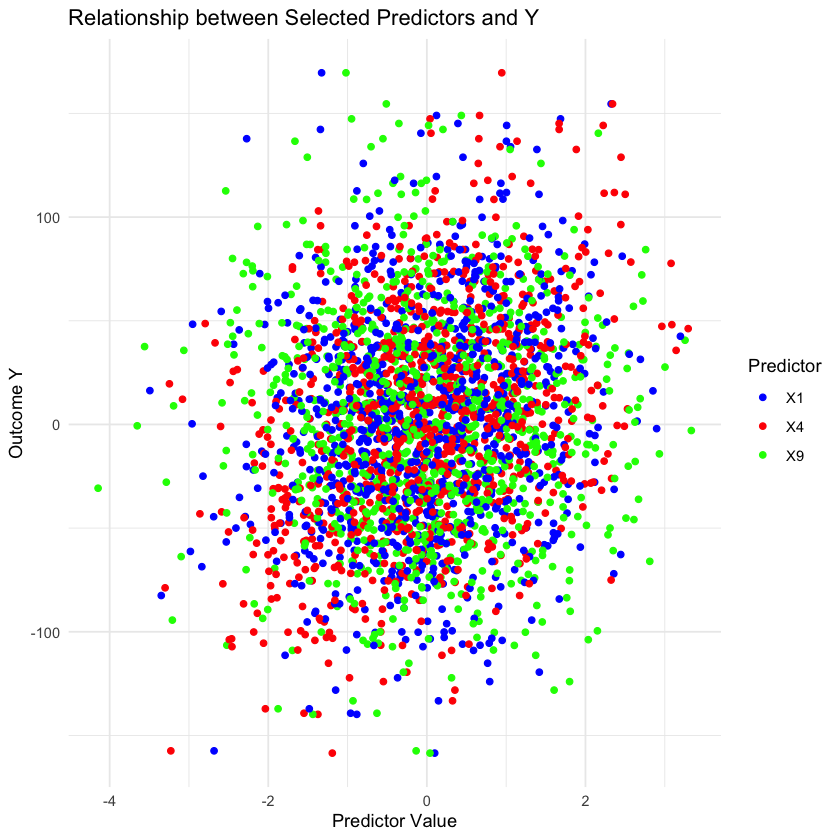

In [9]:
# Select a subset of predictors for visualization
selected_predictors <- c("X1", "X4", "X9")

# Reshape the data to long format for selected predictors
data_long <- pivot_longer(df, cols = selected_predictors, names_to = "Predictor", values_to = "Value")

# Create the plot
ggplot(data_long, aes(x = Value, y = Y, color = Predictor)) + 
  geom_point() + 
  theme_minimal() + 
  labs(title = "Relationship between Selected Predictors and Y", 
       x = "Predictor Value", 
       y = "Outcome Y") + 
  scale_color_manual(values = c("X1" = "blue", "X4" = "red", "X9" = "green"))  # Customize colors

Now lets visualize some of the distributions of two of our features. Visualizing distributions can help you see if features are scaled differently, and to easily tell if data follow a specific distribution. Data being normally distributed is an important assumption of Linear Regression. As you can see, they are both normally distributed:

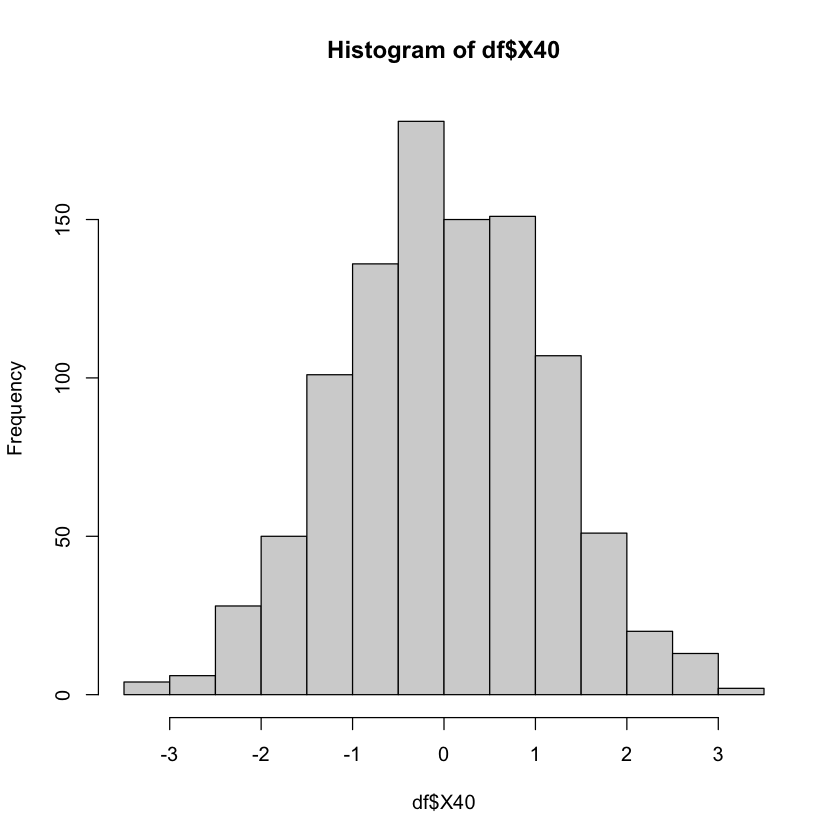

In [10]:
hist(df$X40)

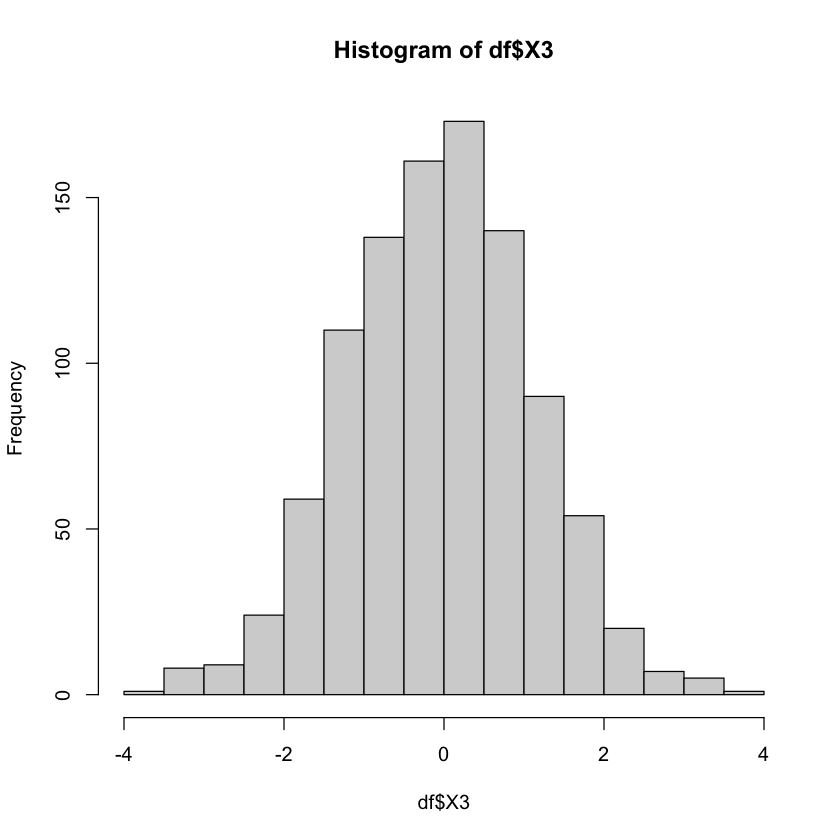

In [11]:
hist(df$X3)

Finally, let's make a correlation matrix of some of our features. This is another useful technique for quickly identifying collinearity in your features. It will be hard to visualize 100 features, so we will only show 6 for this example:

In [29]:
df_subset <- df[, c("X12", "X34", "X42", "X52", "X65", "X86")]

cor(df_subset)

,X12,X34,X42,X52,X65,X86
X12,1.00000000,0.01570159,-0.02633614,0.01841344,0.01081148,-0.01265818
X34,0.01570159,1.00000000,-0.03712181,-0.00959718,0.02855552,-0.06170153
X42,-0.02633614,-0.03712181,1.00000000,0.04322803,-0.06275829,0.02387978
X52,0.01841344,-0.00959718,0.04322803,1.00000000,0.03701207,0.03967546
X65,0.01081148,0.02855552,-0.06275829,0.03701207,1.00000000,-0.01380147
X86,-0.01265818,-0.06170153,0.02387978,0.03967546,-0.01380147,1.00000000


## Scaling Features

Before we fit a model, it is necessary to scale our features, to ensure uniform application of the ridge penalty accross variables of different scales. This will ensure that large coefficients are not unfairly punished by the algorithm. 

It is usually not necessary to scale the outcome variable. Since you would be required to unscale the outcome variable to be able to interpret results in the real world, we will avoid doing so here.

## Test/Train Split

Now, we will split our data into training and test sets. This helps avoid overfitting during model training, and can help evaluate the performance of the model on unseen data, making sure that is learning real information, and not just relationships that appear because of nosie.

In [30]:
set.seed(123)  # For reproducibility
train_index <- sample(1:n_samples, size = round(0.8 * n_samples))
test_index <- setdiff(1:n_samples, train_index)
X_train <- X[train_index, ]
y_train <- y[train_index]
X_test <- X[test_index, ]
y_test <- y[test_index]


R functions like `scale()` will work for feature scaling. In this case, the `glmnet` package will do it automatically when fitting a model, so we do not need to perform scaling ourselves.

# Regularization Parameter (Lambda)

Recall that OLS Regression attempts to minimize the sum of the squared residuals between the training data and the best fit line. N is the number of observations, and i is the index of a given observation:


$\quad RSS(\beta) = \sum_{i=1}^{n} (y_i - (X_i \beta))^2$ 




With Ridge, we will introduce a regularization penalty $\lambda$ into this equation. P refers to the number of parameters in the model:

$\quad RSS_{\text{Ridge}}(\beta) = \sum_{i=1}^{n} (y_i - (X_i \beta))^2 + \lambda \sum_{j=1}^{p} \beta_j^2$


There are many techniques to find the best value for lambda. One of the most common techniques is known as k-fold cross validation. This method splits your testing data into k parts, or folds, including 1 fold to be used as a testing fold for evaluation of model performance within the training set.

For a predefined set of lambda values, the model will be trained k-1 times, and then tested on the testing fold where a metric recording indicating the model's performance will be recorded (Mean Squared Error for regression). Afterwards, a different fold will be set aside as the test fold, and this process will repeat until each fold has been set aside for testing. Once each fold is tested, an average of all of the folds metrics is computed, which is the final cross validation score for a given lambda. The next lambda in the set is tested, and the value of lambda with the best CV score is selected as the optimal value for the final model.

This approach ensures that the lambda picked results in a generalizable model, since it is tested on unseen data during hyperparameter selection before testing.

## Cross Validation

We'll perform cross validation with the `cv.glmnet()` function over a pre-specified range of 1000 values. When you don't specify a range of lambdas to test, glmnet will automatically define one for you.

In [31]:
lambda_values <- 10^seq(-3, 3, length = 1000)

# Perform cross-validation to select the best lambda
cv_ridge_model <- cv.glmnet(X_train, y_train, alpha = 0, lambda = lambda_values, 
                            nfolds = 10, standardize = TRUE)

# Best lambda value
best_lambda <- cv_ridge_model$lambda.min

# Optionally, fit the model again using the best lambda
ridge_model <- glmnet(X_train, y_train, alpha = 0, lambda = best_lambda, standardize = TRUE)

### Plot Cross Validation Scores vs Lambda

Below, we'll plot MSE vs Lambda. In the dataframe, `lambda` corresponds to lambda value, `cvm` corresponds to Cross-Validation Mean (average cross validation score (MSE in this case) across all folds, `cvup` corresponds to the upper bound of the confidence interval for the CVM, and `cvlo` corresponds to it's lower bound. 

In [33]:
cv_scores <- data.frame(lambda = cv_ridge_model$lambda,
                        cvm = cv_ridge_model$cvm,
                        cvup = cv_ridge_model$cvup,
                        cvlo = cv_ridge_model$cvlo)

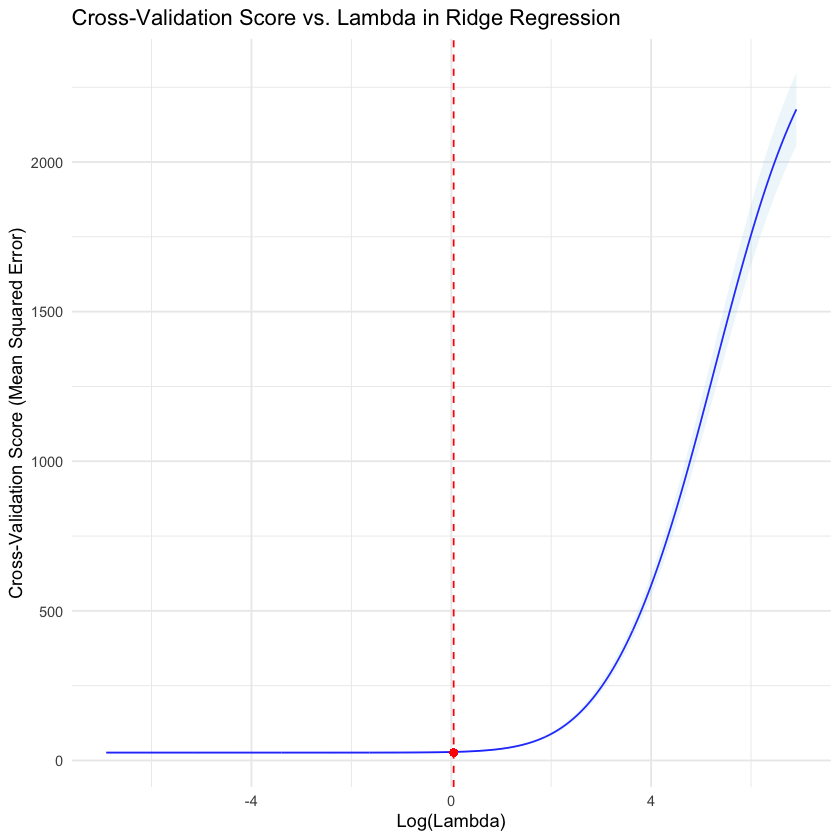

In [16]:
# Find the lambda with the minimum CV mean score (simple approach to inflection)
optimal_lambda <- cv_scores$lambda[which.min(cv_scores$cvm)]

# Plot
ggplot(cv_scores, aes(x = log(lambda), y = cvm)) +
  geom_line(color = "blue") + # Mean CV score line
  geom_ribbon(aes(ymin = cvlo, ymax = cvup), alpha = 0.2, fill = "lightblue") + # Error bands
  geom_vline(xintercept = optimal_lambda, linetype = "dashed", color = "red") + # Highlight optimal lambda
  geom_point(aes(x = optimal_lambda, y = min(cvm)), color = "red") + # Point at inflection
  labs(x = "Log(Lambda)", y = "Cross-Validation Score (Mean Squared Error)", 
       title = "Cross-Validation Score vs. Lambda in Ridge Regression") +
  theme_minimal() 


In [17]:
cat('Best Lambda: ', optimal_lambda)

Best Lambda:  0.0473888

The optimal lambda is the inflection point where MSE stops decreasing and starts increasing. Unforuntately this is hard to visualize in this situation given the scaling of our graph. We can however, still observe this concept by printing CV scores and lambdas around the optimal lambda in our data frame.

We will find the index in our dataframe of the optimal lambda. We will then print out 5 lambda values before and after it to show how lambda is decreasing slowly until this point (index #664), and then starts to increase after:

In [18]:
# Find the index of the row with the optimal lambda
optimal_index <- which.min(abs(cv_scores$lambda - optimal_lambda))

# Calculate the range of indices to select, ensuring it stays within dataframe bounds
start_index <- max(1, optimal_index - 5)
end_index <- min(nrow(cv_scores), optimal_index + 5)

# Slice the dataframe to get 5 rows above and below the optimal lambda row
sliced_df <- cv_scores[start_index:end_index, ]

# View the sliced dataframe
print(sliced_df)

        lambda      cvm     cvup     cvlo
716 0.05078152 26.37369 28.11653 24.63084
717 0.05008408 26.37368 28.11655 24.63080
718 0.04939622 26.37367 28.11658 24.63076
719 0.04871780 26.37366 28.11661 24.63072
720 0.04804870 26.37366 28.11664 24.63068
721 0.04738880 26.37366 28.11667 24.63065
722 0.04673795 26.37366 28.11671 24.63061
723 0.04609604 26.37366 28.11674 24.63058
724 0.04546295 26.37367 28.11678 24.63056
725 0.04483856 26.37368 28.11682 24.63053
726 0.04422274 26.37369 28.11686 24.63051


### Comparison to OLS

Let's evaluate our Ridge model against our OLS model on our test set:

In [34]:
# Fit OLS model
ols_model <- lm(y_train ~ X_train)

# Evaluate performance of ridge and OLS on test set
ols_pred <- predict(ols_model, data.frame(X_test))
ridge_pred <- predict(ridge_model, X_test)
ols_rmse <- sqrt(mean((y_test - ols_pred)^2))
ridge_rmse <- sqrt(mean((y_test - ridge_pred)^2))
cat("OLS RMSE:", ols_rmse, "\n")
cat("Ridge RMSE:", ridge_rmse, "\n")

Warning message:
"'newdata' avait 200 lignes mais les variables trouv'ees ont 800 lignes"


OLS RMSE: 71.84047 
Ridge RMSE: 5.084413 


As expected, our Ridge model had a lower error than the OLS model, with a Root-Mean-Squared-Error (RMSE) of 5.08 vs 71.84:

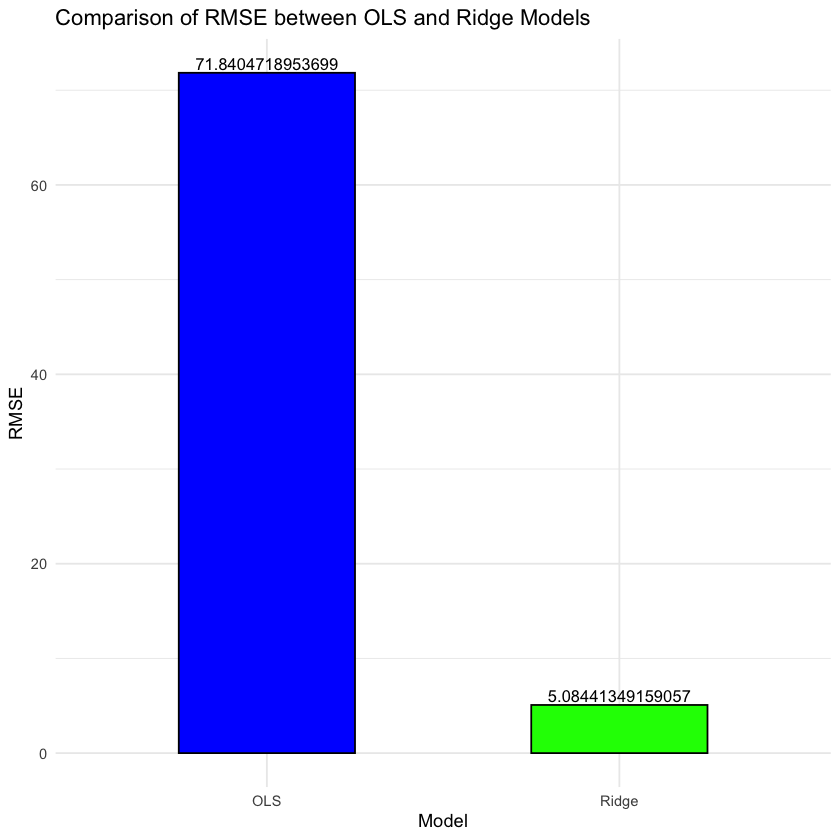

In [67]:
rmse_data <- data.frame(Model = c("OLS", "Ridge"), RMSE = c(ols_rmse, ridge_rmse))

ggplot(rmse_data, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity", color = "black", fill = c("blue", "green"), width = 0.5) +
  geom_text(aes(label = RMSE), vjust = -0.3, color = "black", size = 3.5, position = position_dodge(width = 0.9)) +
  labs(title = "Comparison of RMSE between OLS and Ridge Models",
       x = "Model", y = "RMSE") +
  theme_minimal()
